In [1]:
from pathlib import Path

from forecasting_models.lstm.model import LSTMForecastModel
import numpy as np
from data_utils.preprocessing import init_preprocess, resample_timeseries_dataframe
from data_utils.csv_utils import read_timeseries_csv


lstm_model = LSTMForecastModel(Path("__file__").parent / Path("examples/configs/lstm/lstm_config_example.yaml"))

2024-02-28 14:25:45.070881: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 14:25:45.072903: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 14:25:45.099771: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 14:25:45.099807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 14:25:45.100576: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

<Axes: xlabel='timestamp'>

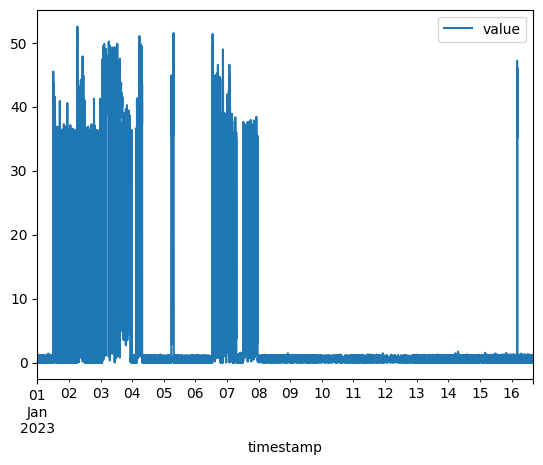

In [2]:
train_df = read_timeseries_csv(lstm_model.config.data_path)
train_df.plot()

<Axes: xlabel='timestamp'>

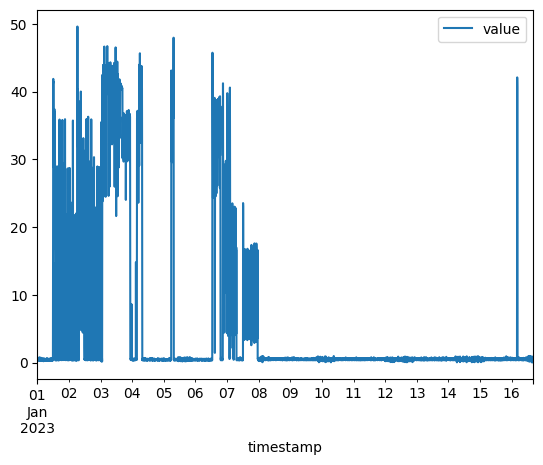

In [3]:
train_df = init_preprocess(
    train_df,
    base_step=lstm_model.config.preprocessing_parameters.initial_timedelta,
)
train_df = resample_timeseries_dataframe(
    train_df,
    step=lstm_model.config.preprocessing_parameters.target_timedelta,
)
train_df.plot()

In [4]:
import tensorflow as tf

tf.random.set_seed(50)
np.random.seed(50)


In [5]:
from tensorflow.keras.layers import LSTM

history = lstm_model.train(
    custom_inner_layers=[
        LSTM(16),
    ]
)

Epoch 1/100
113/113 [==============================] - 7s 19ms/step - loss: 0.0078 - mean_absolute_error: 0.0521 - val_loss: 6.7569e-04 - val_mean_absolute_error: 0.0145
Epoch 2/100
113/113 [==============================] - 1s 8ms/step - loss: 0.0043 - mean_absolute_error: 0.0316 - val_loss: 5.3992e-04 - val_mean_absolute_error: 0.0059
Epoch 3/100
113/113 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_absolute_error: 0.0309 - val_loss: 7.3114e-04 - val_mean_absolute_error: 0.0158
Epoch 4/100
113/113 [==============================] - 1s 9ms/step - loss: 0.0042 - mean_absolute_error: 0.0303 - val_loss: 6.1144e-04 - val_mean_absolute_error: 0.0117
Epoch 5/100
113/113 [==============================] - 1s 9ms/step - loss: 0.0042 - mean_absolute_error: 0.0297 - val_loss: 6.2959e-04 - val_mean_absolute_error: 0.0133
Epoch 6/100
113/113 [==============================] - 1s 9ms/step - loss: 0.0041 - mean_absolute_error: 0.0302 - val_loss: 6.8595e-04 - val_mean_absolut

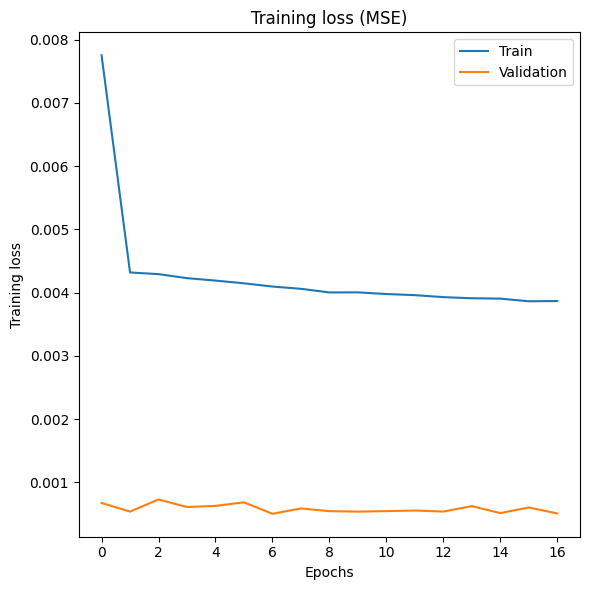

In [6]:
lstm_model.plotter.plot_training_loss(history)

<Axes: xlabel='timestamp'>

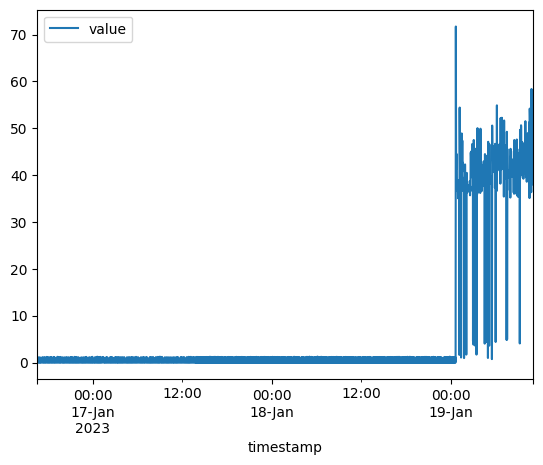

In [7]:
test_df = read_timeseries_csv(Path("./examples/sample_data/resource_usage_example_TEST.csv"))
test_df.plot()

(798, 1)


<Axes: xlabel='timestamp'>

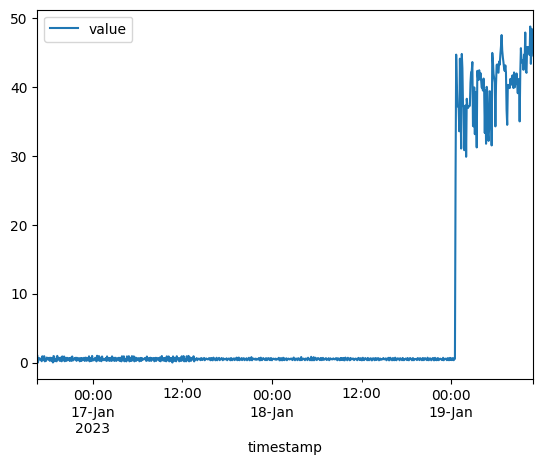

In [8]:
test_df_preprocessed = init_preprocess(
    test_df,
    base_step=lstm_model.config.preprocessing_parameters.initial_timedelta,
)
test_df_preprocessed = resample_timeseries_dataframe(
    test_df_preprocessed,
    step=lstm_model.config.preprocessing_parameters.target_timedelta,
)

print(test_df_preprocessed.shape)
test_df_preprocessed.plot()

In [9]:
init_inputs = train_df[-lstm_model.config.forecasting_parameters.input_width:]["value"]
print(init_inputs)

actuals, preds = lstm_model.test(
    test_df,
    init_inputs=init_inputs,
)

timestamp
2023-01-16 16:05:00    0.355722
2023-01-16 16:10:00    0.648733
2023-01-16 16:15:00    0.264214
2023-01-16 16:20:00    0.715619
2023-01-16 16:25:00    0.706766
2023-01-16 16:30:00    0.248290
Freq: 5T, Name: value, dtype: float64
1/1 [==============================] - 0s 22ms/step


In [10]:
test_eval_val, test_eval_df = lstm_model.evaluate_test(actuals, preds, method="mape")

In [11]:
print(test_eval_df)

                        actual  predicted      diff
2023-01-16 16:35:00   0.955621   0.437502  0.518119
2023-01-16 16:40:00   0.007500   0.433433 -0.425933
2023-01-16 16:45:00   0.645425   0.801844 -0.156419
2023-01-16 16:50:00   0.445010   1.185396 -0.740386
2023-01-16 16:55:00   0.606107   0.867770 -0.261663
...                        ...        ...       ...
2023-01-19 10:40:00  43.364818  41.316059  2.048759
2023-01-19 10:45:00  46.298526  40.257773  6.040753
2023-01-19 10:50:00  48.388678  40.446302  7.942376
2023-01-19 10:55:00  47.379692  39.188126  8.191567
2023-01-19 11:00:00  44.573609  38.242888  6.330720

[798 rows x 3 columns]


In [12]:
print(test_eval_val)

91.31113231056706


<Axes: >

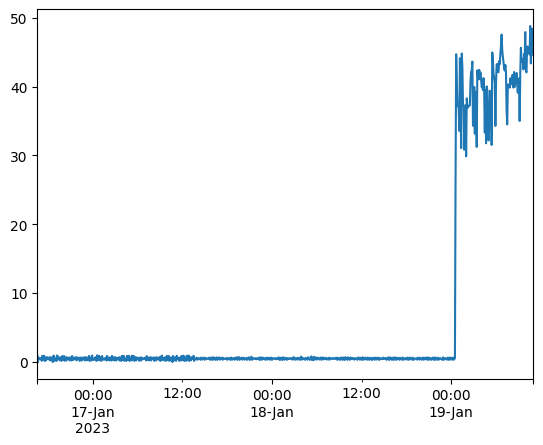

In [13]:
actuals.plot()

<Axes: >

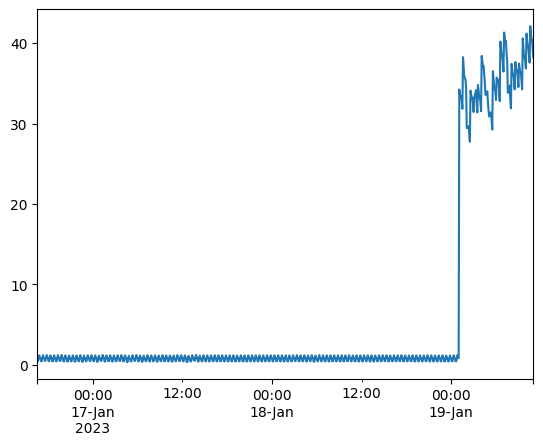

In [14]:
preds.plot()

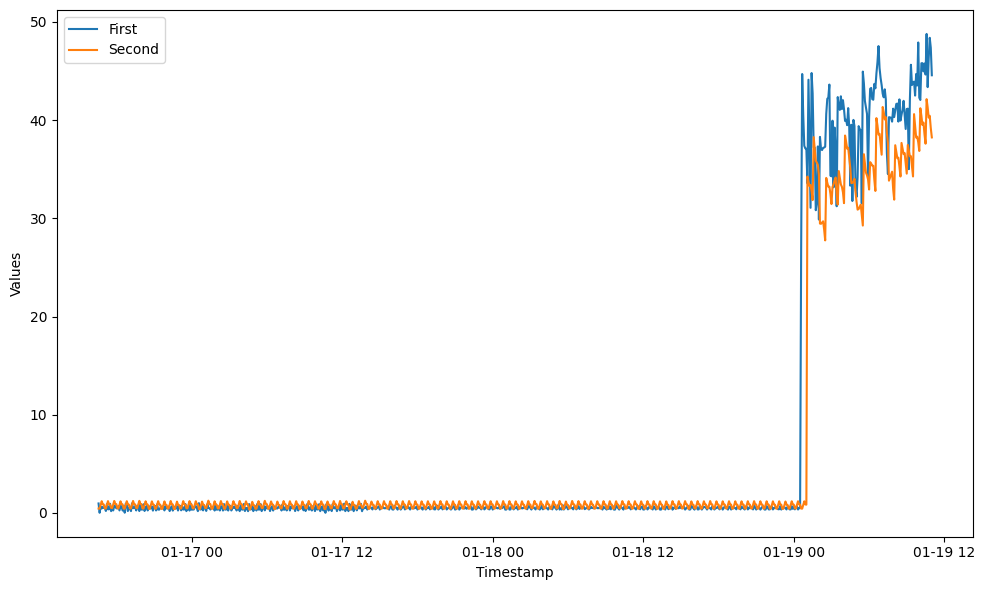

In [15]:
lstm_model.plotter.plot_two_series(actuals, preds)

In [16]:
anomaly_df = lstm_model.flag_anomalies(actuals, preds, 20)

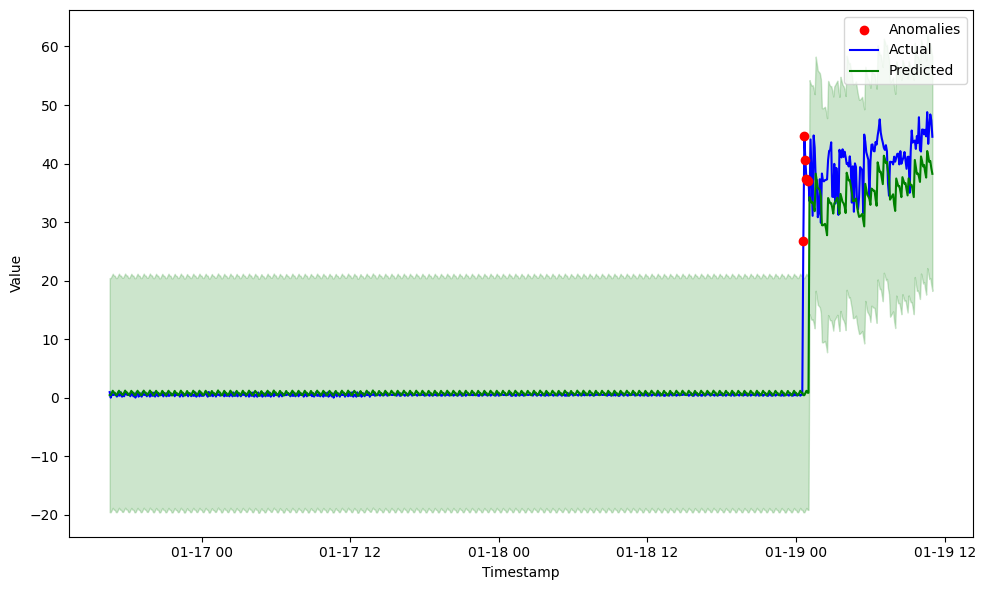

In [17]:
lstm_model.plotter.plot_anomalies(anomaly_df, 20)

<Axes: xlabel='timestamp'>

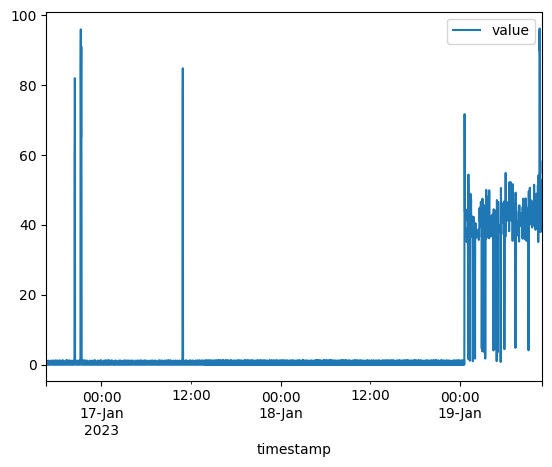

In [18]:
test_df_w_anomalies = read_timeseries_csv(Path("./examples/sample_data/resource_usage_example_ANOMALY_TEST.csv"))
test_df_w_anomalies.plot()

<Axes: xlabel='timestamp'>

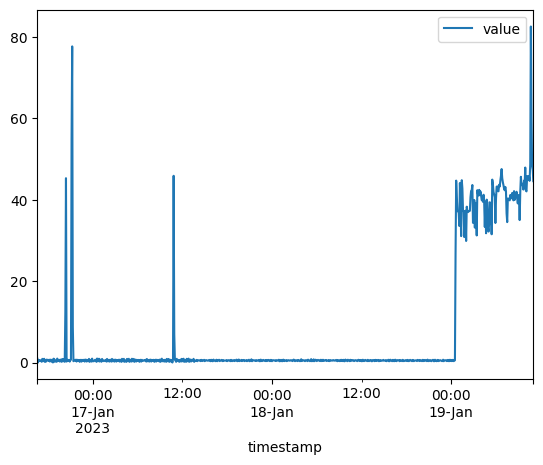

In [19]:
test_df_w_anomalies_preprocessed = init_preprocess(
    test_df_w_anomalies,
    base_step=lstm_model.config.preprocessing_parameters.initial_timedelta,
)
test_df_w_anomalies_preprocessed = resample_timeseries_dataframe(
    test_df_w_anomalies_preprocessed,
    step=lstm_model.config.preprocessing_parameters.target_timedelta,
)
test_df_w_anomalies_preprocessed.plot()

In [20]:
anomaly_actuals, anomaly_preds = lstm_model.test(test_df_w_anomalies, init_inputs)

1/1 [==============================] - 0s 20ms/step


In [21]:
new_anomaly_df = lstm_model.flag_anomalies(anomaly_actuals, anomaly_preds, 20)

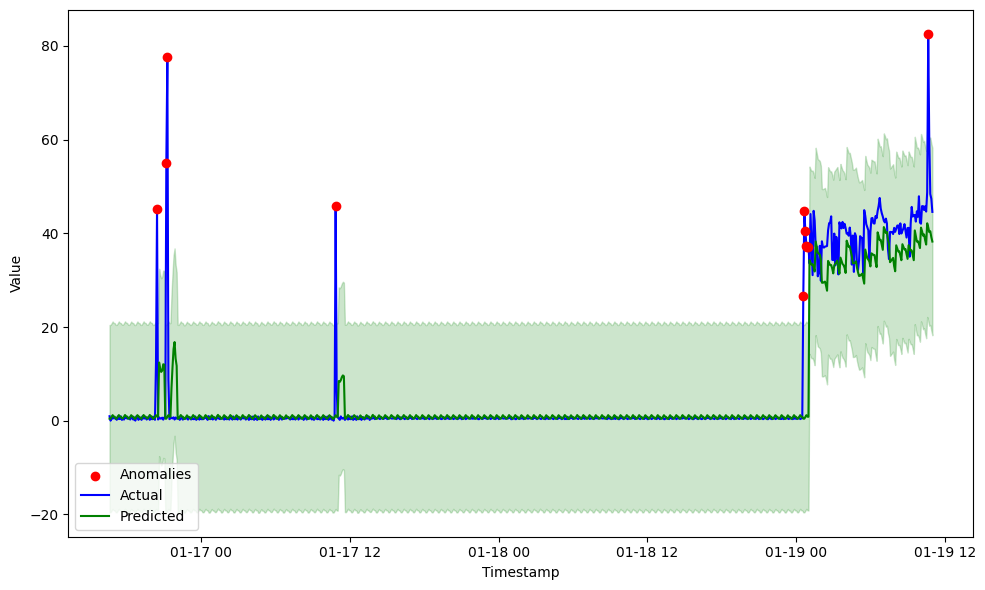

In [22]:
lstm_model.plotter.plot_anomalies(new_anomaly_df, 20)

In [23]:
single_shot_prediction_inputs = train_df[:lstm_model.config.forecasting_parameters.input_width]["value"]
print(single_shot_prediction_inputs)

timestamp
2023-01-01 00:00:00    0.458009
2023-01-01 00:05:00    0.482082
2023-01-01 00:10:00    0.347365
2023-01-01 00:15:00    0.630353
2023-01-01 00:20:00    0.316106
2023-01-01 00:25:00    0.489296
Freq: 5T, Name: value, dtype: float64


In [24]:
single_shot_predictions = lstm_model.predict(single_shot_prediction_inputs)
print(single_shot_predictions)

1/1 [==============================] - 1s 711ms/step
2023-01-01 00:30:00    0.396920
2023-01-01 00:35:00    0.394659
2023-01-01 00:40:00    0.762137
2023-01-01 00:45:00    1.143466
2023-01-01 00:50:00    0.821292
2023-01-01 00:55:00    0.795830
Freq: 5T, dtype: float64


In [31]:
single_shot_prediction_actuals = train_df[
    lstm_model.config.forecasting_parameters.input_width:(
            lstm_model.config.forecasting_parameters.input_width + lstm_model.config.forecasting_parameters.output_width
        )]["value"]

single_shot_eval_val, single_shot_eval_df = lstm_model.evaluate_prediction(single_shot_prediction_actuals, method="mse")

In [32]:
print(single_shot_eval_df)

                       actual  predicted      diff
2023-01-01 00:30:00  0.490616   0.396920  0.093696
2023-01-01 00:35:00  0.490828   0.394659  0.096169
2023-01-01 00:40:00  0.348003   0.762137 -0.414133
2023-01-01 00:45:00  0.465542   1.143466 -0.677923
2023-01-01 00:50:00  0.607025   0.821292 -0.214267
2023-01-01 00:55:00  0.313061   0.795830 -0.482769


In [33]:
print(single_shot_eval_val)

0.15468165460403763
